# Overview of SST products

Analyse the representation of SST fine scale variability for different models.

# Packages

In [1]:
import intake
from easygems import healpix as egh
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import math


import sys
sys.path.append('/home/b/b383497/hk25-teams/hk25-ShallowCirc/src/')
from toolbox import attach_coords
sys.path.append('/home/b/b383497/hk25-ASintTrops/Scripts/lfdavoli/')
from geometry import nan_gaussian_filter

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

# Functions

In [2]:
def worldmap(var, **kwargs):
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    egh.healpix_show(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

# Data extraction

In [3]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["EU"]
#list(cat)

In [4]:
print(pd.DataFrame(cat["ifs_tco3999-ng5_rcbmf"].describe()["user_parameters"]))
ifs_zoom = 11
ifs_time_res = 'PT1H'
ifs_ds = cat["ifs_tco3999-ng5_rcbmf"](zoom=ifs_zoom,time=ifs_time_res).to_dask()  # this does NOT use dask, see note below
# Drop lat and lon to avoid conflicts later
ifs_ds = ifs_ds.drop_vars(['lat','lon'])
ifs_ds

   name                       description type      allowed default
0   dim  2D and 3D version of the dataset  str     [2D, 3D]      2D
1  time    time resolution of the dataset  str  [PT1H, P1M]    PT1H
2  zoom         zoom level of the dataset  int      [7, 11]       7


KeyboardInterrupt: 

In [5]:
print(pd.DataFrame(cat["nicam_gl11"].describe()["user_parameters"]))
nicam_zoom = 9
nicam_time_res = 'PT3H'
nicam_ds = cat["nicam_gl11"](zoom=nicam_zoom,time=nicam_time_res).to_dask()  # this does NOT use dask, see note below
nicam_ds

   name                     description type                         allowed  \
0  time  time resolution of the dataset  str              [PT1H, PT3H, PT6H]   
1  zoom  zoom resolution of the dataset  int  [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]   

  default  
0    PT3H  
1       0  


<xarray.Dataset> Size: 1TB
Dimensions:    (time: 2920, cell: 3145728, bnds: 2)
Coordinates:
    lev        float64 8B ...
  * time       (time) datetime64[ns] 23kB 2020-03-01T01:30:00 ... 2021-02-28T...
Dimensions without coordinates: cell, bnds
Data variables: (12/30)
    clivi      (time, cell) float32 37GB ...
    clt        (time, cell) float64 73GB ...
    clwvi      (time, cell) float32 37GB ...
    healpix    int32 4B ...
    hflsd      (time, cell) float32 37GB ...
    hfssd      (time, cell) float32 37GB ...
    ...         ...
    rsutcs     (time, cell) float32 37GB ...
    tas        (time, cell) float64 73GB ...
    time_bnds  (time, bnds) datetime64[ns] 47kB ...
    ts         (time, cell) float64 73GB ...
    uas        (time, cell) float64 73GB ...
    vas        (time, cell) float64 73GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    comment:      Be careful that definition of time coordinate depends on th...
    history:      Mon Apr 07 16:48:41 2025: cdo mergetime ./z09/2020/03/3hour...
    title:        NICAM data output

## Define regions and day, HealPix to latlon

In [6]:
regions = {
    'gulf_stream' : {
        'long_name' : 'Gulf Stream',
        'short_name' : 'gulf_stream',
        'boundaries' : [-83,-30,30,55], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
    },    
    'gulf_stream_detail' : {
        'long_name' : 'Gulf Stream - detail',
        'short_name' : 'gulf_stream_detail',
        'boundaries' : [-73,-58,35,40], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
    },    
    'tropical_atlantic' : {
        'long_name' : 'Tropical Atlantic',
        'short_name' : 'tropical_atlantic',
        'boundaries' : [-62,15,-20,20], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
    },
    'tropical_atlantic_detail' : {
        'long_name' : 'Tropical Atlantic - detail',
        'short_name' : 'tropical_atlantic_detail',
        'boundaries' : [-40,-25,-5,0], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
    },
    'eurec4a' : {
        'long_name' : '$EUREC^{4}A$',
        'short_name' : 'eurec4a',
        'boundaries' : [-62,-48,4,16], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
    },
}

region = 'gulf_stream'
ifs_time = '2020-05-01T00:00:00.000000000'
nicam_time = '2020-05-01T01:30:00.000000000'
ifs_latlon_gridstep = 0.01 # [°]
nicam_latlon_gridstep = 0.04 # [°]

#supersampling = {"lon": 2, "lat": 2}
#ifs_idx = get_nn_lon_lat_index(2**ifs_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], ifs_latlon_gridstep/supersampling['lon']), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], ifs_latlon_gridstep/supersampling['lat']))
#ifs_sst = ifs_ds.sst.sel(time=ifs_time).isel(value=ifs_idx).coarsen(supersampling).mean()
ifs_idx = get_nn_lon_lat_index(2**ifs_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], ifs_latlon_gridstep), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], ifs_latlon_gridstep))
ifs_sst = ifs_ds.sst.sel(time=ifs_time).isel(value=ifs_idx)

nicam_idx = get_nn_lon_lat_index(2**nicam_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], nicam_latlon_gridstep), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], nicam_latlon_gridstep))
nicam_ts = nicam_ds.ts.sel(time=nicam_time).isel(cell=nicam_idx)


# Analyses

## Regional map, no filter

Text(0.5, 0.98, 'No filter - Gulf Stream')

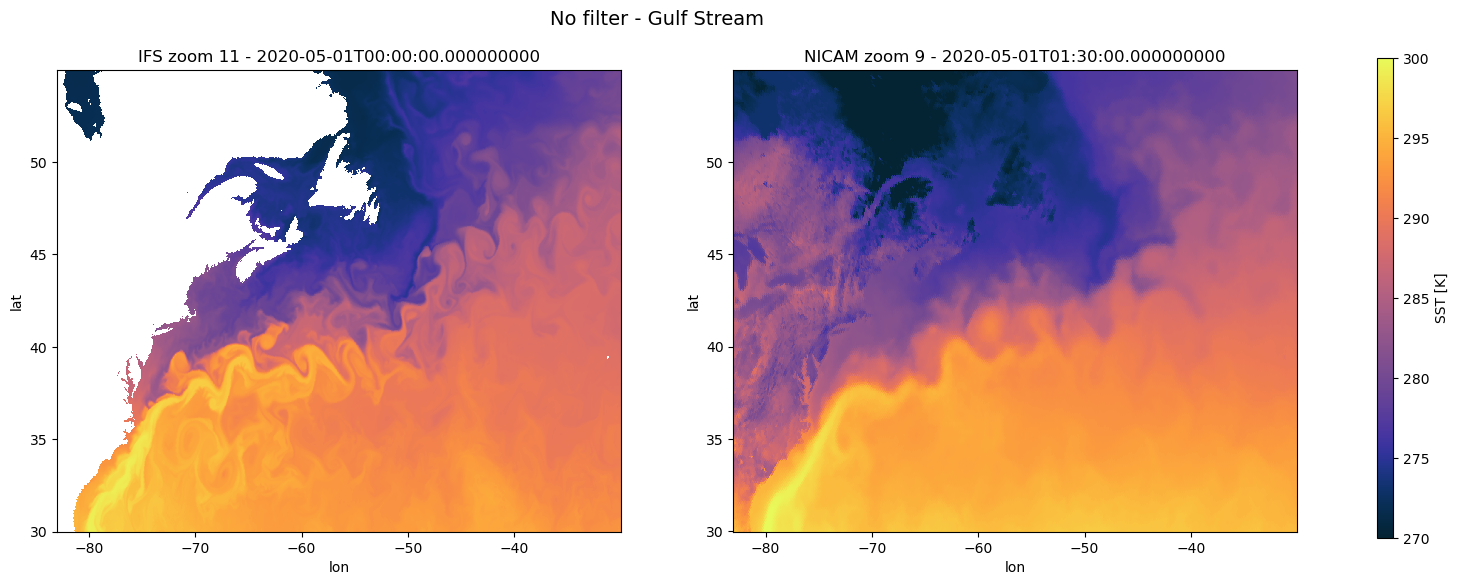

In [9]:
#projection = ccrs.Robinson(central_longitude=10)
cmap = cmocean.cm.thermal

fig, axes = plt.subplots(
    1,
    2,
    figsize=(16, 6), 
    #subplot_kw={"projection": projection}, 
    #constrained_layout=True,
)

# IFS
ax = axes[0]
#ax.set_extent(regions[region]['boundaries'], crs=ccrs.PlateCarree())
#ifs_map = ax.imshow(ifs_sst, cmap=cmap)
ifs_map = ifs_sst.plot(ax=ax,cmap=cmap,vmin=270,vmax=300,add_colorbar=False)
#ax.add_feature(cf.COASTLINE, linewidth=0.8)
#ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.set_title(f'IFS zoom {ifs_zoom} - {ifs_sst.time.data}')
#gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#gl.top_labels = False
#gl.right_labels = False
#gl.xlabel_style = {'size': 10}
#gl.ylabel_style = {'size': 10}

# NICAM
ax = axes[1]
#ax.set_extent(regions[region]['boundaries'], crs=ccrs.PlateCarree())
nicam_map = nicam_ts.plot(ax=ax, cmap=cmap,vmin=270,vmax=300,add_colorbar=False)
#ax.add_feature(cf.COASTLINE, linewidth=0.8)
#ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.set_title(f'NICAM zoom {nicam_zoom} - {nicam_ts.time.data}')
#gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#gl.top_labels = False
#gl.right_labels = False
#gl.xlabel_style = {'size': 10}
#gl.ylabel_style = {'size': 10}

cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
fig.colorbar(ifs_map, cax=cbar_ax,label='SST [K]')
fig.suptitle(f"No filter - {regions[region]['long_name']}", fontsize=14)

## Regional map, sst anomaly high-pass 25km

/home/b/b383497/hk25-teams/hk25-ASintTrops/Scripts/lfdavoli/geometry.py:110: RuntimeWarning: divide by zero encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/home/b/b383497/hk25-teams/hk25-ASintTrops/Scripts/lfdavoli/geometry.py:110: RuntimeWarning: invalid value encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field


Text(0.5, 0.98, 'High-pass 25km - Gulf Stream')

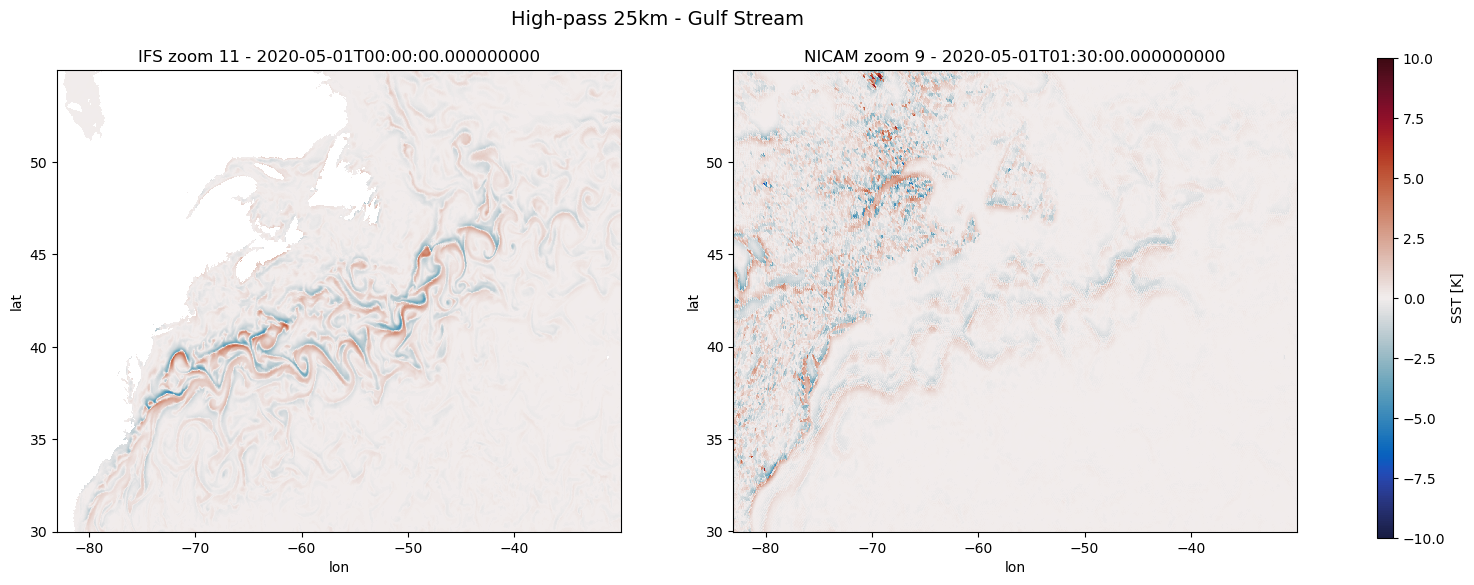

In [10]:
ifs_sigma = 25 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 25km smoothing
nicam_sigma = 6 # [gridstep], for nicam_zoom = 9 => 0.04° => 24km smoothing

cmap = cmocean.cm.balance

fig, axes = plt.subplots(
    1,
    2,
    figsize=(16, 6), 
)


# IFS
# To latlon
ifs_smooth_sst = nan_gaussian_filter(ifs_sst,ifs_sigma)
ifs_sst_anomaly = ifs_sst - ifs_smooth_sst
ax = axes[0]
ifs_map = ifs_sst_anomaly.plot(ax=ax,cmap=cmap,vmin=-10,vmax=10,add_colorbar=False)
ax.set_title(f'IFS zoom {ifs_zoom} - {ifs_sst.time.data}')


# NICAM
# To latlon
nicam_smooth_ts = nan_gaussian_filter(nicam_ts,nicam_sigma)
nicam_ts_anomaly = nicam_ts - nicam_smooth_ts
ax = axes[1]
nicam_map = nicam_ts_anomaly.plot(ax=ax, cmap=cmap,vmin=-10,vmax=10,add_colorbar=False)
ax.set_title(f'NICAM zoom {nicam_zoom} - {nicam_ts.time.data}')

cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
fig.colorbar(ifs_map, cax=cbar_ax,label='SST [K]')
fig.suptitle(f"High-pass 25km - {regions[region]['long_name']}", fontsize=14)